In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [3]:
# df = pd.read_csv("system_metrics_ramp_up.csv")
df = pd.read_csv("sudden_spike_data.csv")
df.head()

,Time,CPU,Memory,Disk
0,19-05-2025 09:14,1.014901,2.069968,1.472993
1,19-05-2025 09:15,0.995852,2.046232,1.494219
2,19-05-2025 09:16,1.019431,2.002982,1.468303
3,19-05-2025 09:17,1.045691,1.967653,1.487682
4,19-05-2025 09:18,0.992975,2.034911,1.424255


In [4]:
features = ["CPU", "Memory", "Disk"]
df = df.set_index("Time")

In [5]:
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
model = LocalOutlierFactor(n_neighbors=50, contamination=0.005)
predictions = model.fit_predict(X_scaled)
df['is_anomaly'] = predictions


In [7]:
anomalies = df[df['is_anomaly'] == -1]

print(f"\n--- Analysis Complete ---")
print(f"Total data points: {len(df)}")
print(f"Number of anomalies detected: {len(anomalies)}")

if len(anomalies) > 0:
    print("\n--- Detected Anomalies (Timestamps and Values) ---")
    print(anomalies)
else:
    print("\nNo anomalies were detected with the current settings.")


--- Analysis Complete ---
Total data points: 1000
Number of anomalies detected: 5

--- Detected Anomalies (Timestamps and Values) ---
                       CPU    Memory      Disk  is_anomaly
Time                                                      
19-05-2025 12:43  1.115582  2.087479  1.499972          -1
19-05-2025 13:36  0.902762  2.026938  1.549431          -1
19-05-2025 19:14  1.522710  2.990855  2.024938          -1
19-05-2025 22:44  1.115582  2.087479  1.499972          -1
19-05-2025 23:37  0.902762  2.026938  1.549431          -1



Generating plots...


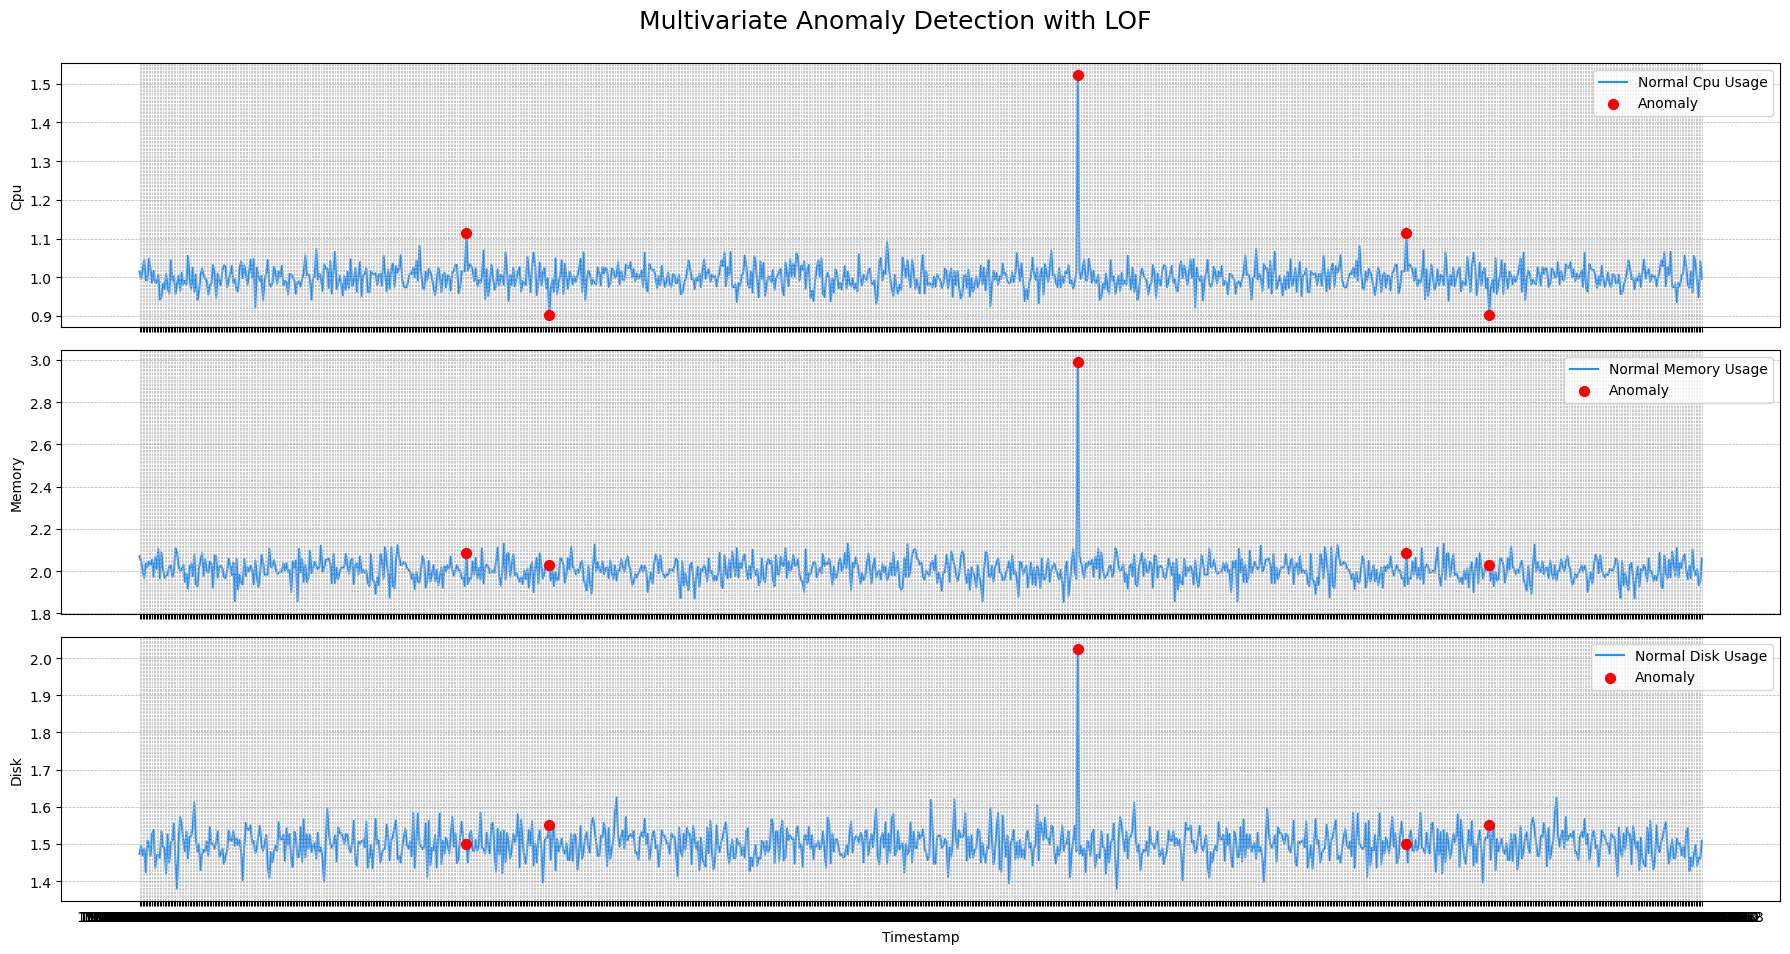

In [8]:
if len(anomalies) > 0:
    print("\nGenerating plots...")

    # Create subplots, one for each feature
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(18, 10), sharex=True)
    if len(features) == 1: # Matplotlib returns a single axes object if nrows=1
        axes = [axes]

    fig.suptitle('Multivariate Anomaly Detection with LOF', fontsize=18, y=0.95)

    for i, feature in enumerate(features):
        # Plot the original time series data
        axes[i].plot(df.index, df[feature], label=f'Normal {feature.capitalize()} Usage', color='dodgerblue', zorder=1)

        # Highlight the detected anomalies with red dots
        axes[i].scatter(
            anomalies.index,
            anomalies[feature],
            color='red',
            s=50,
            zorder=2, # Make sure dots are on top
            label='Anomaly'
        )

        axes[i].set_ylabel(feature.capitalize())
        axes[i].legend(loc='upper right')
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.xlabel('Timestamp')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [9]:
# Add a new column for the plotly legend labels based on LOF results
df['LOF Anomaly Label'] = df['is_anomaly'].apply(lambda x: 'LOF Anomaly' if x == -1 else 'Inlier')

# --- Identify the ground truth anomaly point ---
# Define the specific timestamp and approximate values of the ground truth anomaly
ground_truth_timestamp = '2025-05-19 19:14:00'
ground_truth_cpu = 1.52271
ground_truth_memory = 2.990855
ground_truth_disk = 2.024938

# Create a boolean mask to find the row corresponding to the ground truth anomaly
# Use `np.isclose` for floating point comparisons to avoid precision issues
ground_truth_mask = (df.index == ground_truth_timestamp) & \
                    np.isclose(df['CPU'], ground_truth_cpu, atol=1e-4) & \
                    np.isclose(df['Memory'], ground_truth_memory, atol=1e-4) & \
                    np.isclose(df['Disk'], ground_truth_disk, atol=1e-4)

# Create the final 'Anomaly Category' column
# Start with the LOF labels, then overwrite the ground truth point
df['Anomaly Category'] = df['LOF Anomaly Label']
df.loc[ground_truth_mask, 'Anomaly Category'] = 'Ground Truth Anomaly'


fig = px.scatter_3d(
    df.reset_index(),  # Reset index to use 'Time' in hover data
    x='CPU',
    y='Memory',
    z='Disk',
    color='Anomaly Category',      # Color by our 3-category column
    symbol='Anomaly Category',     # Use different shapes for each category

    # Define the specific colors and symbols for our three categories
    color_discrete_map={
        'Inlier': 'dodgerblue',
        'LOF Anomaly': 'red',
        'Ground Truth Anomaly': 'gold' # A distinct, bright color
    },
    symbol_map={
        'Inlier': 'circle',
        'LOF Anomaly': 'diamond',
        'Ground Truth Anomaly': 'circle' # Changed 'square' back to 'circle' for a dot
    },

    hover_data={'Time': True}, # Show timestamp on hover
    title='3D View: LOF Anomalies vs. Ground Truth Anomaly'
)

# --- Customize marker sizes for better visibility ---
# Make the Inliers small
fig.update_traces(marker_size=3, selector=dict(name='Inlier'))
# Make the LOF-detected anomalies a bit larger
fig.update_traces(marker_size=6, selector=dict(name='LOF Anomaly'))
# Make our Ground Truth point extra large and prominent
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', selector=dict(name='Ground Truth Anomaly'))


fig.show()